# Disaster Tweets - Predicting Disaster Occurences from Twitter texts

Automated determination of likely disasters from building a model to monitor tweets.  This notebook involved exploratory data analysis, model building, and performance evaluation.

The target metric to optimize is the F1 score (harmonic mean of precision and recall).  The target prediction variable is binary. The goal is to predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## About the data
Sounce of the dataset is from Twitter.  It is a collection of tweets that are labeled to indicate if they are describing an actual disaster or not.

There are three datasets: train.csv (training set), test.csv (test set) and sample_submission.csv (an example of the submission in the correct format).

What is the format of the data?
    Each sample in the train and test set has the following information:

    text: The text of a tweet
    keyword: A keyword from that tweet (although this may be blank!)
    location: The location the tweet was sent from (may also be blank)

    Columns
        id - a unique identifier for each tweet
        text - the text of the tweet
        location - the location the tweet was sent from (may be blank)
        keyword - a particular keyword from the tweet (may be blank)
        target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

An example of a tweet from the dataset (from the dataset description on Kaggle):
"The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine."

Source:
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here. https://www.figure-eight.com/data-for-everyone/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


In [2]:
# set up Keras multi-backend version
!pip install keras-core --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: keras-nlp
    Found existing installation: keras-nlp 0.9.3
    Uninstalling keras-nlp-0.9.3:
      Successfully uninstalled keras-nlp-0.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


Set up required libraries for EDA, analysis, and modeling

In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#from keras.optimizers import adam

print("Tensorflow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-05-31 14:40:52.886827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:40:52.886988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:40:53.066625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
Tensorflow version: 2.15.0
KerasNLP version: 0.12.1


## Load the data

Load data from the train and test files.  This section also includes some basic analysis of the data.

In [5]:
# load training data
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

print("\ntrain data sample")
df_train.head()


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB

train data sample


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


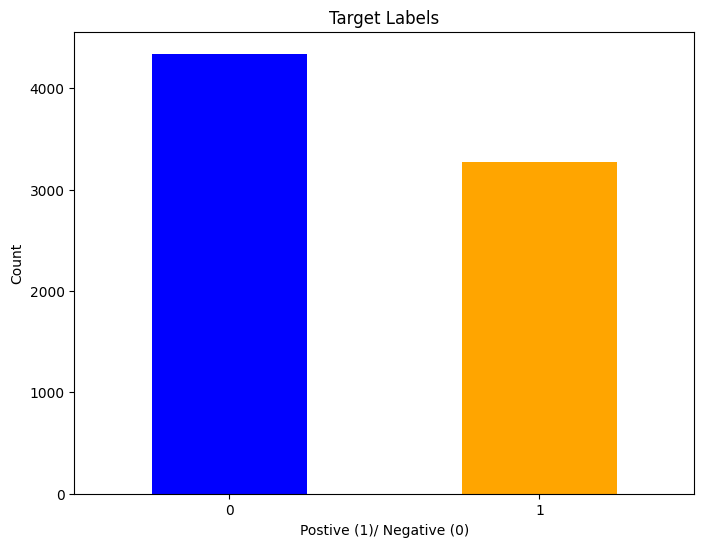

In [7]:
# review the balance of 0 vs 1 in the target column

# count the occurrences of each category
category_counts = df_train['target'].value_counts()

# plot the bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Target Labels')
plt.xlabel('Postive (1)/ Negative (0)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

There are more negative (not disaster) tweets than positive, but the labels are not too imbalanced with over 3000 examples of positive (1) disaster labels.

In [8]:
print("\ntest data sample")
df_test.head()


test data sample


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


## Preprocessing data

In [10]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 4 #2
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

# create the train anad test split with a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

## Initial NLP Modeling
Using DistilBERT as starting point.

Text inputs need to be converted into numeric token IDs and arranged into Tensors before being fed into BERT.

The BertClassifier model can include a preprocessor layer, which automatically handles raw input preprocessing during fit(), predict(), and evaluate() methods. This occurs by default when the model is created using from_preset().

The DistilBERT model will be chosen. DistilBERT is a simplified version of BERT that maintains 97% of BERT's performance while using only half the number of parameters.

DistilBERT has 40% fewer parameters than bert-base-uncased, runs 60% faster, and retains over 95% of BERT's performance on the GLUE benchmark. It achieves this by removing token-type embeddings and the pooler, and by retaining only half of the layers from Google's BERT.

In [12]:
# load model
preset= "distil_bert_base_en_uncased"

# shorten sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# use pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# compile model, use Adam optimizer and sparse categorical cross-entropy to start.  accuracy metric target
from keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# set loss function
loss_function = SparseCategoricalCrossentropy(from_logits=True)

# set the optimizer
#opt = Adam(lr=0.001, weight_decay=1e-6)
opt = Adam(1e-5)

classifier.compile(
    loss=loss_function,
    optimizer=opt,
    metrics= ["accuracy"]  
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4
191/191 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7793

W0000 00:00:1717166604.108842     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717166608.565205     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 135s 535ms/step - loss: 0.4841 - accuracy: 0.7793 - val_loss: 0.3932 - val_accuracy: 0.8431


W0000 00:00:1717166616.399090     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/4
191/191 [==============================] - 88s 463ms/step - loss: 0.3686 - accuracy: 0.8498 - val_loss: 0.3830 - val_accuracy: 0.8464
Epoch 3/4
191/191 [==============================] - 89s 465ms/step - loss: 0.3152 - accuracy: 0.8777 - val_loss: 0.3911 - val_accuracy: 0.8470
Epoch 4/4
191/191 [==============================] - 89s 466ms/step - loss: 0.2668 - accuracy: 0.9039 - val_loss: 0.4281 - val_accuracy: 0.8319


## Initial modeling results analysis

Review loss over the epochs for train versus validation data.

In [14]:
# create function to plot loss comparison as it will be used many times
def plot_loss_comparison(history, name):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'Model Loss {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

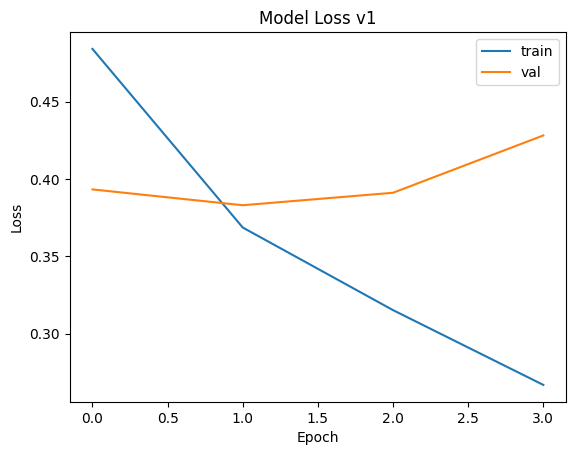

In [15]:
plot_loss_comparison(history,"v1")

In [16]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster (0)","Disaster (1)"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

  2/191 [..............................] - ETA: 33s 

W0000 00:00:1717166887.349087     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 30s 143ms/step


W0000 00:00:1717166914.567629     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


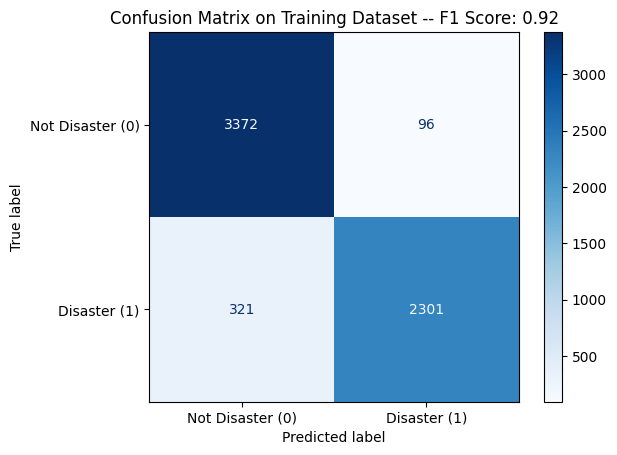

In [17]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

some diagnostic info on the datasets for test and validation

In [18]:
print(y_pred_train.shape)
#print(y_pred_train[:10])
print(y_pred_train)

(6090, 2)
[[-2.0035398   2.0245934 ]
 [ 0.9301276  -0.9757855 ]
 [-2.0616689   2.0491002 ]
 ...
 [ 1.0339824  -0.8951108 ]
 [-1.9248921   1.9303278 ]
 [ 0.39681116 -0.34478465]]


In [19]:
print(y_train.shape)
#print(y_train[:10])
print(y_train)

(6090,)
4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64


In [20]:
print(np.argmax(y_pred_train, axis=1))

[1 0 1 ... 0 1 0]


48/48 [==============================] - 8s 165ms/step


W0000 00:00:1717166924.049354     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


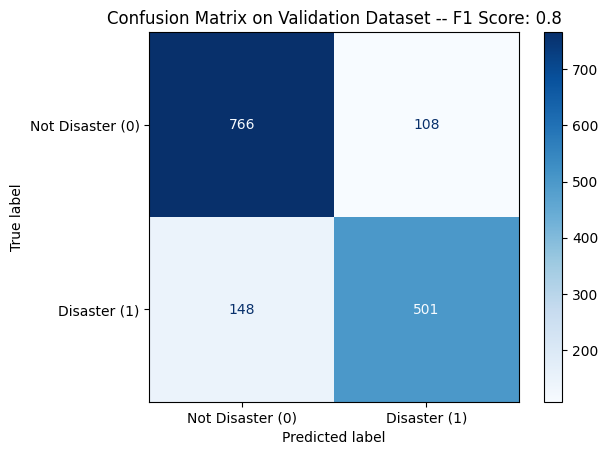

In [21]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

### Discussion of initial results
Accuracy measure ~0.90 and an F1 score of 0.91 on test data indicate a useful model can be learned.  Optimizer used was Sparse Categorical Crossentropy that generated Logits for each class.  The max logit determined the predicted class.

The F1 score on validation data was lower, as would be expected, at 0.8.  This indicates there may be some improvement to be had and current model may have some overfitting.  The comparion of training loss versus validation loss indicates a quick divergence and further indicates overfitting.

## Hyperparameter tuning
Before moving on to other models, some attempts at tuning hyperparameters to see if performance improves

In [22]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [23]:
# Set Optimizer
#adjust learning rate and a few other parameters, see if there is an impact
opt = optimizer

classifier.compile(
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    loss=loss_function,
    # optimizer=keras.optimizers.Adam(1e-5),
    optimizer=opt,
    metrics= ["accuracy"]  
)

# fit model
history2 = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4


W0000 00:00:1717166952.902311     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5553

W0000 00:00:1717167046.933677     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717167050.740147     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 132s 551ms/step - loss: 0.6962 - accuracy: 0.5553 - val_loss: 0.6847 - val_accuracy: 0.5739


W0000 00:00:1717167057.949113     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/4
191/191 [==============================] - 89s 465ms/step - loss: 0.7364 - accuracy: 0.5629 - val_loss: 0.6829 - val_accuracy: 0.5739
Epoch 3/4
191/191 [==============================] - 88s 463ms/step - loss: 0.6864 - accuracy: 0.5695 - val_loss: 0.6861 - val_accuracy: 0.5739
Epoch 4/4
191/191 [==============================] - 88s 463ms/step - loss: 0.6848 - accuracy: 0.5695 - val_loss: 0.6830 - val_accuracy: 0.5739


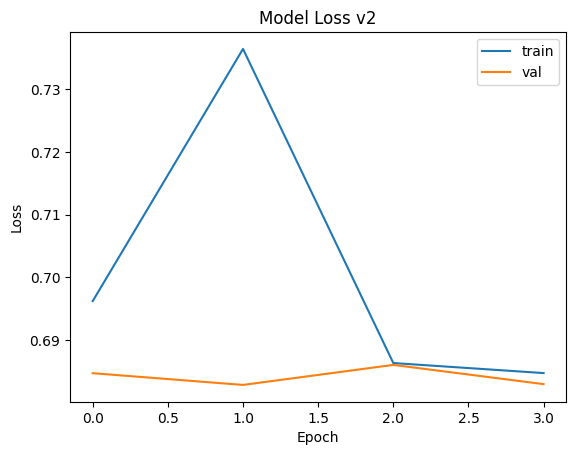

In [24]:
plot_loss_comparison(history2,"v2")

 2/48 [>.............................] - ETA: 8s  

W0000 00:00:1717167328.003632     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 [==============================] - 10s 152ms/step


W0000 00:00:1717167335.132696     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


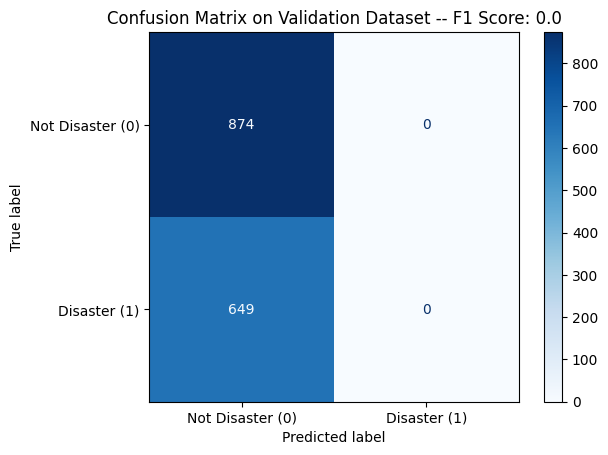

In [25]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

Although accuracy and F1 scores are lower with this iteration, there is less divergence between train and validation loss.  Adjusting the learning rate and see if there is improvement

In [26]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [27]:
# Set Optimizer
#adjust learning rate and a few other parameters, see if there is an impact
opt = optimizer

classifier.compile(
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    loss=loss_function,
    # optimizer=keras.optimizers.Adam(1e-5),
    optimizer=opt,
    metrics= ["accuracy"]  
)

# fit model
history3 = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4


W0000 00:00:1717167364.045766     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5657

W0000 00:00:1717167457.735628     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717167461.574212     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 132s 549ms/step - loss: 0.6855 - accuracy: 0.5657 - val_loss: 0.6822 - val_accuracy: 0.5739


W0000 00:00:1717167468.728233     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/4
191/191 [==============================] - 89s 465ms/step - loss: 0.6851 - accuracy: 0.5695 - val_loss: 0.6828 - val_accuracy: 0.5739
Epoch 3/4
191/191 [==============================] - 88s 463ms/step - loss: 0.6846 - accuracy: 0.5695 - val_loss: 0.6826 - val_accuracy: 0.5739
Epoch 4/4
191/191 [==============================] - 88s 463ms/step - loss: 0.6843 - accuracy: 0.5695 - val_loss: 0.6828 - val_accuracy: 0.5739


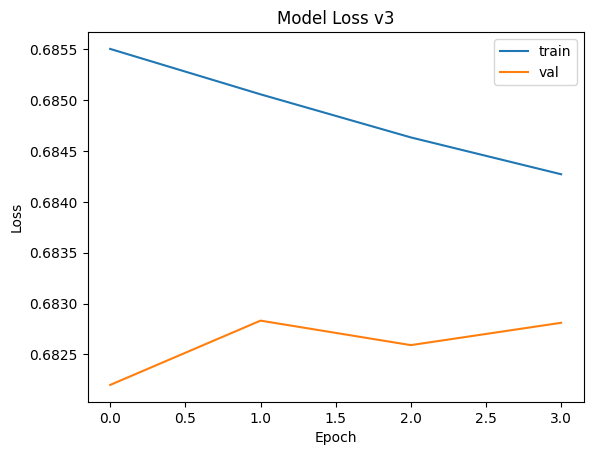

In [28]:
plot_loss_comparison(history3,"v3")

## Model fitting v2 - using LSTM
In this section, a Long Short Term Memory model (in the RNN family) is used in an attempt to improve the F1 scores.

In [29]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


from bs4 import BeautifulSoup
def clean_text(text):
    # clean out things like url and punctuation, etc
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\x00-\x7F.]', ' ', text)
    text = re.sub(f'[{re.escape(string.punctuation.replace(".", ""))}]', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\.{2,}', '', text)
    text = re.sub(r'(?<=\.)\s+', ' ', text).strip()
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Clean out unnecessary characters, punctuation, and URLs - use the regular expressions and Beautiful Soup functionality

In [30]:
clean_data=lambda text:clean_text(text)
df_train["clean_text"]=df_train["text"].apply(clean_data)

/tmp/ipykernel_34/159660090.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Apply the preprocessing function to the cleaned text

In [31]:
preprocess_data=lambda text:preprocess_text(text)
df_train["text_preprocess"]=df_train["clean_text"].apply(preprocess_data)

In [ ]:
#check for floats in indexes
float_indexes = []
for index, value in df_train['text_preprocess'].items():
    if isinstance(value, float):
        float_indexes.append(index)
print("Indexes that are Floats in the 'documents':", float_indexes)

Indexes that are Floats in the 'documents': []


No floats, this is good

In [ ]:
#check for nulls in indexes
null_indexes = []
for index, value in df_train['text_preprocess'].items():
    if pd.isnull(value) or value.strip() == "":
        null_indexes.append(index)
print("Indexes that are null in 'text_preprocess':", null_indexes)

Indexes that are null in 'text_preprocess': []


No nulls, this is also good

In [ ]:
X=df_train.drop(["id","keyword","location","text","target","clean_text"],axis=1)
y=df_train["target"]

In [ ]:
def preprocess_text2(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

Tokenize and clean the preprocessed text

In [ ]:
tokenized_documents=[preprocess_text2(doc) for doc in X["text_preprocess"]]

In [ ]:
from gensim.models import Word2Vec
vector_size=100
word2vec_model = Word2Vec(sentences=tokenized_documents, 
                          min_count=1, vector_size=vector_size,sg=1)

In [ ]:
all_words =word2vec_model.wv.index_to_key
print("20 top tokens with Word2Vec:")
for index, word in enumerate(all_words):
    if index < 20:
        print(f"{word} : {index}")
    else:
        break

20 top tokens with Word2Vec:
. : 0
like : 1
fire : 2
get : 3
im : 4
bomb : 5
new : 6
via : 7
one : 8
peopl : 9
go : 10
news : 11
dont : 12
kill : 13
burn : 14
video : 15
flood : 16
crash : 17
emerg : 18
time : 19


In [ ]:
sequences = [[word2vec_model.wv.key_to_index[word] for word in text] 
             for text in [preprocess_text2(doc) for doc in df_train['text_preprocess']]]

In [ ]:
max_length = max([len(seq) for seq in sequences])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

y=np.asarray(y)

Redo the train, test, validation split on the processed text data for the LSTM model

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(padded_sequences,y,
                    test_size=0.2,random_state=42, stratify=y)

In [ ]:
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, word2vec_model.vector_size))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# number of labels
num_labels = len(np.unique(y))
print(num_labels)

2


### Build LSTM model

Build an RNN using LSTM and a categorization neural net on top.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input,Embedding,GlobalMaxPooling1D
from keras.initializers import GlorotUniform

In [ ]:
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], 
                  trainable=False))
model.add(LSTM(vector_size,kernel_initializer=GlorotUniform(), return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_labels*2, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_labels, activation='softmax'))

Set up evaluation metrics to more closely monitor F1 score performance since that is the target metric

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Set up optimizer, use sparse categorical crossentropy loss (again).  Start learning rate at 0.0025

In [ ]:
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                                                      metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                                     restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                    patience=10, min_lr=0.0001)

In [ ]:
history_lstm = model.fit(X_train, y_train, epochs=200, batch_size=256, 
          validation_data=(X_val, y_val), callbacks=[early_stopping,reduce_lr])

#epochs attempted up to 1000 but showing at 200 to save time

Epoch 1/200
24/24 [==============================] - 6s 35ms/step - loss: 0.6844 - accuracy: 0.5678 - f1_m: 0.6005 - precision_m: 0.4299 - recall_m: 1.0000 - val_loss: 0.6814 - val_accuracy: 0.5706 - val_f1_m: 0.6007 - val_precision_m: 0.4295 - val_recall_m: 1.0000 - lr: 0.0025
Epoch 2/200
24/24 [==============================] - 0s 10ms/step - loss: 0.6753 - accuracy: 0.5691 - f1_m: 0.6003 - precision_m: 0.4295 - recall_m: 1.0000 - val_loss: 0.6625 - val_accuracy: 0.5778 - val_f1_m: 0.6007 - val_precision_m: 0.4295 - val_recall_m: 1.0000 - lr: 0.0025
Epoch 3/200
24/24 [==============================] - 0s 9ms/step - loss: 0.6456 - accuracy: 0.6351 - f1_m: 0.6004 - precision_m: 0.4296 - recall_m: 1.0000 - val_loss: 0.6430 - val_accuracy: 0.6271 - val_f1_m: 0.6007 - val_precision_m: 0.4295 - val_recall_m: 1.0000 - lr: 0.0025
Epoch 4/200
24/24 [==============================] - 0s 8ms/step - loss: 0.6416 - accuracy: 0.6383 - f1_m: 0.6002 - precision_m: 0.4294 - recall_m: 1.0000 - val_los

In [ ]:
loss, accuracy, f1, precision, recall = model.evaluate(X_val, y_val, verbose=0)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')

Loss: 0.54
Accuracy: 74.13%
F1 Score: 59.54%


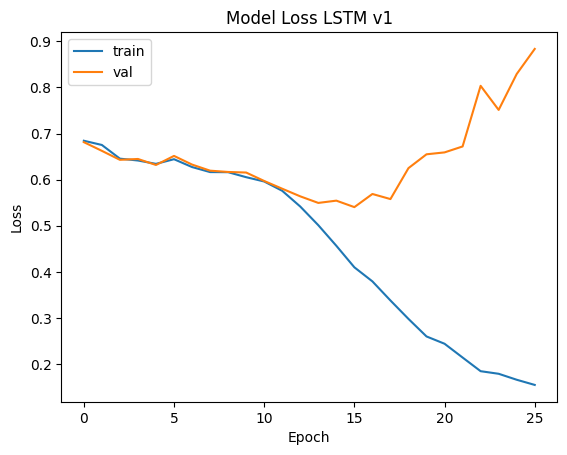

In [ ]:
plot_loss_comparison(history_lstm,"LSTM v1")

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(report)

48/48 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       869
           1       0.75      0.59      0.66       654

    accuracy                           0.74      1523
   macro avg       0.74      0.72      0.73      1523
weighted avg       0.74      0.74      0.74      1523



## Summary and Conclusions

The results indicate the validation loss improves until later in the training process where it increases while the training loss still decreases.  This indicates the model is overfitting and cannot generalize to new data. It performs well on the training data but poorly on the validation set. The validation loss initially decreases but then starts to increase.

This can happen if the model is too complex or trained for too long. To prevent this, training can be stopped when the loss is low and stable, a technique known as early stopping. Early stopping is a common method to prevent overfitting.  The code already has early stopping built in, so more tweaking of the hyperparameters for the early stopping function should improve results.

Overall, the initial transformer based model (DistilBERT) is performing better and will be used in the submission.  However, the LSTM model indicates more potential robustness on new data if the overfitting problems are solved.  More experimentation is needed.

## Generate file for Submission

The submission.csv file uses the following format: id,target

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Since the modified BERT transformer model was best performing, this one will be submitted.

In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
# sample_submission["target"] = np.argmax(model.predict(X_test), axis=1)

  2/102 [..............................] - ETA: 17s 

W0000 00:00:1717167784.595596     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 [==============================] - 18s 148ms/step


W0000 00:00:1717167799.522434     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.0
mean,5427.152927,0.0
std,3146.427221,0.0
min,0.000000,0.0
25%,2683.000000,0.0
50%,5500.000000,0.0
75%,8176.000000,0.0
max,10875.000000,0.0


In [ ]:
sample_submission.to_csv("submission.csv", index=False)

Save model to file for submission

In [ ]:
model.save("lstm_model.keras")
word2vec_model.save("word2vec_model1.model")

## Attributions
Custom keras metrics: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

NLP starter notebook: https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets

LSTM example notebook: https://www.kaggle.com/code/nandaprasetia/nlp-with-disaster-tweet-lstm